## Imports

In [88]:
import os
import json
import copy
import glob 

import numpy as np
import pandas as pd
import iris
import iris.cube # Ensures the 'cube' module is loaded
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy

## Useful Functions

In [3]:
def ext(cube,region):
    """Extract region from cube."""
    return cube.intersection(longitude=(region[0], region[2]), latitude=(region[1], region[3]))


def prepare_for_merge(cube, realization):
    """Prepare cube for merging, for ensemble statistics."""
    cube.var_name = 'n_gb_mean'
    realization_coord = iris.coords.AuxCoord(np.int32(realization), "realization", units="1")
    try:
        cube.add_aux_coord(realization_coord)
    except Exception as e:
        pass
    return cube


def area_avg_cube(cube):
    """Calculate an area-weighted average of cube."""
    if type(cube) == iris.cube.Cube:
        if not cube.coord('latitude').has_bounds():
            cube.coord('latitude').guess_bounds()
        if not cube.coord('longitude').has_bounds():
            cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)
        
        new_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    
    else:
        raise TypeError('Function only accepts cubes')
    
    return new_cube

def get_ensemble_statistics_2(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
    for p in cubes_c1:
        realization = 0
        for c1 in cubes_c1[p]:
            c1 = prepare_for_merge(c1, realization)
            realization += 1
        realization = 0
        for c2 in cubes_c2[p]:
            c2 = prepare_for_merge(c2, realization)
            realization += 1
        realization = 0
        for c3 in cubes_c3[p]:
            c3 = prepare_for_merge(c3, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]

    return stats

def get_regional_stats_2(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][0], region))
        area_mean['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][0], region))
        area_mean['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][0], region))
        
        area_med['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][1], region))
        area_med['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][1], region))
        area_med['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][1], region))
        
        area_max['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][2], region))
        area_max['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][2], region))
        area_max['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][2], region))
        
        area_min['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][3], region))
        area_min['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][3], region))
        area_min['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][3], region))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_frac_2(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][0][:, :5]), region))
        area_mean['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][0][:, :5]), region))
        area_mean['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][0][:, :5]), region))
        
        area_med['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][1][:, :5]), region))
        area_med['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][1][:, :5]), region))
        area_med['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][1][:, :5]), region))
        
        area_max['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][2][:, :5]), region))
        area_max['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][2][:, :5]), region))
        area_max['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][2][:, :5]), region))
        
        area_min['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][3][:, :5]), region))
        area_min['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][3][:, :5]), region))
        area_min['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][3][:, :5]), region))
        
    return [area_mean, area_med, area_max, area_min]

def get_ensemble_statistics(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    cubes_c4 = cube_dict['ssprcmip_ssp534_over']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}, 'ssprcmip_ssp534_over': {}}
    for p in cubes_c1:
        realization = 0
        for (c1, c2, c3, c4) in zip(cubes_c1[p], cubes_c2[p], cubes_c3[p], cubes_c4[p]):
            c1 = prepare_for_merge(c1, realization)
            c2 = prepare_for_merge(c2, realization)
            c3 = prepare_for_merge(c3, realization)
            c4 = prepare_for_merge(c4, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])
        iris.util.equalise_attributes(cubes_c4[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()
        mm_cube_c4 = cubes_c4[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)
        c4_mean = mm_cube_c4.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)
        c4_median = mm_cube_c4.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)
        c4_max = mm_cube_c4.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)
        c4_min = mm_cube_c4.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]
        stats['ssprcmip_ssp534_over'][p] = [c4_mean, c4_median, c4_max, c4_min]

    return stats

def get_regional_stats(cubes, region):
    cubes = copy.deepcopy(cubes)
    for scenario in cubes:
        for p in cubes[scenario]:
            for i, _ in enumerate(cubes[scenario][p]):
                cubes[scenario][p][i] = area_avg_cube(ext(cubes[scenario][p][i], region))
        
    return cubes


def get_regional_stats_frac(cubes, region):
    cubes = copy.deepcopy(cubes)
    for scenario in cubes:
        for p in cubes[scenario]:
            for i, _ in enumerate(cubes[scenario][p]):
                cubes[scenario][p][i] = area_avg_cube(ext(np.sum(cubes[scenario][p][i][:, :5]), region))
        
    return cubes


def moving_average(x, w, decs):
    arr = np.ones(decs)
    for i in range(decs):
        arr[i] = np.mean(x[i*w:i*w+w])

    return arr

## Load in all the JULES and FaIR data

This requires a fair (no pun intended) bit of memory

In [4]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
fair_dict_path = f'{parent_dir}/data/ForestRisks_Zenodo/FaIR_output/fair_2300_dict.json'
fair_path = f'{parent_dir}/data/ForestRisks_Zenodo/FaIR_output'
jules_data_path = f'{parent_dir}/data/ForestRisks_Zenodo/JULES_output'

with open(fair_dict_path) as f:
    fair_dict = json.load(f)

percentiles = ['0.0', '0.01', '0.05', '0.25', '0.5', '0.75', '0.95', '0.99', '1.0']
scenarios = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
variables = ['t1p5m_gb', 'precip', 'npp_n_gb', 'frac']
t1p5m_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
precip_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
npp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
frac_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}

for root, dirs, files in os.walk(jules_data_path):
    for file in files:
        for scenario in scenarios:
            for p in percentiles:
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[0]}_ens.nc')):
                    t1p5m_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[1]}_ens.nc')):
                    precip_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[2]}_ens.nc')):
                    npp_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[3]}_ens.nc')):
                    frac_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(jules_data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))

Load in FaIR data

In [69]:
ren_list = glob.glob(fair_path + '/*C1-IMP-Ren_temp.dat')
neg_list = glob.glob(fair_path + '/*C2-IMP-Neg_temp.dat')
gs_list = glob.glob(fair_path + '/*C3-IMP-GS_temp.dat')

ren = []
neg = []
gs = []

for (r, n, g) in zip(ren_list, neg_list, gs_list):
    df = pd.read_csv(r, delimiter=' ', names=['year', 'val'])
    df.drop('year', axis=1, inplace=True)
    df.columns = [r.split('/')[-1].split('_')[0]]
    ren.append(df)
    
    df = pd.read_csv(n, delimiter=' ', names=['year', 'val'])
    df.drop('year', axis=1, inplace=True)
    df.columns = [n.split('/')[-1].split('_')[0]]
    neg.append(df)
    
    df = pd.read_csv(g, delimiter=' ', names=['year', 'val'])
    df.drop('year', axis=1, inplace=True)
    df.columns = [g.split('/')[-1].split('_')[0]]
    gs.append(df)

ren = pd.concat(ren, axis=1)
neg = pd.concat(neg, axis=1)
gs = pd.concat(gs, axis=1)

time = np.arange(1850, 2300, 10)
decs = len(time)

gtemp_dict = {
    'C1-IMP-Ren': {},
    'C2-IMP-Neg': {},
    'C3-IMP-GS': {},
}
for scen in scenarios:
    for p in percentiles:
        gtemp_dict['C1-IMP-Ren'][p] = moving_average(ren[fair_dict[scen][p]][-455:].values, 10, decs)
        gtemp_dict['C2-IMP-Neg'][p] = moving_average(neg[fair_dict[scen][p]][-455:].values, 10, decs)
        gtemp_dict['C3-IMP-GS'][p] = moving_average(gs[fair_dict[scen][p]][-455:].values, 10, decs)

Define time and number of decades for the rest of the notebook

In [6]:
time = np.arange(2000, 2300, 10)
decs = len(time)

In [7]:
time_coord = t1p5m_cubes['C1-IMP-Ren']['0.01'][0].coord('time')
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            t1p5m_cubes[scen][p][i].remove_coord('time')
            t1p5m_cubes[scen][p][i].add_dim_coord(time_coord, 0)

            precip_cubes[scen][p][i].remove_coord('time')
            precip_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            
            npp_cubes[scen][p][i].remove_coord('time') 
            npp_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            
            frac_cubes[scen][p][i].remove_coord('time')
            frac_cubes[scen][p][i].add_dim_coord(time_coord, 0)

##### Pop problematic models from cubelists:

- NorESM2-LM
- KACE-1-0-G
- E3SM-1-0

In [8]:
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if model.attributes['source'].split('/')[6].split('_')[0] in ['NorESM2-LM', 'KACE-1-0-G', 'E3SM-1-0']:
                t1p5m_cubes[scen][p].pop(i)
                precip_cubes[scen][p].pop(i)
                frac_cubes[scen][p].pop(i)
                npp_cubes[scen][p].pop(i)    

Define regions

In [9]:
# define region. Allows running notebook for different regions
region = {
    "amazon": [-90,-40,-15,10],
    "siberia": [45, 45, 135, 80],
    "global": [-180, -90, 180, 90]
}

In [10]:
%%capture
npp_stats = get_ensemble_statistics_2(npp_cubes)
t1p5m_stats = get_ensemble_statistics_2(t1p5m_cubes)
frac_stats = get_ensemble_statistics_2(frac_cubes)

In [11]:
%%capture
npp_area_list_amazon_stats = get_regional_stats_2(npp_stats, region=region['amazon'])
t1p5m_area_list_amazon_stats = get_regional_stats_2(t1p5m_stats, region=region['amazon'])
frac_area_list_amazon_stats = get_regional_stats_frac_2(frac_stats, region=region['amazon'])

npp_area_list_siberia_stats = get_regional_stats_2(npp_stats, region=region['siberia'])
t1p5m_area_list_siberia_stats = get_regional_stats_2(t1p5m_stats, region=region['siberia'])
frac_area_list_siberia_stats = get_regional_stats_frac_2(frac_stats, region=region['siberia'])

t1p5m_area_list_global_stats = get_regional_stats_2(t1p5m_stats, region=region['global'])

Get all ESM responses for Amazon and Siberia

In [12]:
%%capture
npp_area_list_amazon = get_regional_stats(npp_cubes, region=region['amazon'])
t1p5m_area_list_amazon = get_regional_stats(t1p5m_cubes, region=region['amazon'])
precip_area_list_amazon = get_regional_stats(precip_cubes, region=region['amazon'])
frac_area_list_amazon = get_regional_stats_frac(frac_cubes, region=region['amazon'])

npp_area_list_siberia = get_regional_stats(npp_cubes, region=region['siberia'])
t1p5m_area_list_siberia = get_regional_stats(t1p5m_cubes, region=region['siberia'])
precip_area_list_siberia = get_regional_stats(precip_cubes, region=region['siberia'])
frac_area_list_siberia = get_regional_stats_frac(frac_cubes, region=region['siberia'])

Calculate region areas

In [13]:
# calculate amazon grid area
area_cube = iris.load_cube(f'{parent_dir}/data/ForestRisks_Zenodo/JULES_output/gmtchange_es_area.nc')
amazon_area = np.sum(ext(area_cube, region['amazon']).data) * 1e6 # km2 = m2
siberia_area = np.sum(ext(area_cube, region['siberia']).data) * 1e6 # km2 = m2
amazon_conv = amazon_area / 1e12 # conv: kg m-2 y-1 -> PgC
siberia_conv = siberia_area / 1e12 # conv: kg m-2 y-1 -> PgC

Calculate regional temp anomaly

In [14]:
%%capture
# Calculate regional temperature anomaly 1850-1900
temp_mean_amazon = copy.deepcopy(t1p5m_area_list_amazon)
for scen in scenarios:
    for p in percentiles:
        for i, _ in enumerate(temp_mean_amazon[scen][p]):
            temp_mean_amazon[scen][p][i] = temp_mean_amazon[scen][p][i] - temp_mean_amazon[scen][p][i][:5].collapsed('time', iris.analysis.MEAN)
        
temp_mean_siberia = copy.deepcopy(t1p5m_area_list_siberia)
for scen in scenarios:
    for p in percentiles:
        for i, _ in enumerate(temp_mean_siberia[scen][p]):
            temp_mean_siberia[scen][p][i] = temp_mean_siberia[scen][p][i] - temp_mean_siberia[scen][p][i][:5].collapsed('time', iris.analysis.MEAN)

Plot all scenarios, percentiles, all models

In [15]:
frac_amazon = copy.deepcopy(frac_area_list_amazon)
temp_amazon = copy.deepcopy(temp_mean_amazon) # Anomaly
precip_amazon = copy.deepcopy(precip_area_list_amazon)
npp_amazon = copy.deepcopy(npp_area_list_amazon)

frac_siberia = copy.deepcopy(frac_area_list_siberia)
temp_siberia = copy.deepcopy(temp_mean_siberia) # Anomaly
precip_siberia = copy.deepcopy(precip_area_list_siberia)
npp_siberia = copy.deepcopy(npp_area_list_siberia)

Calculate 2000-2020 mean (for present day baseline period)

In [16]:
%%capture
# Calculate stats to get ensemble mean
npp_stats_amazon = get_ensemble_statistics_2(npp_area_list_amazon)
frac_stats_amazon = get_ensemble_statistics_2(frac_area_list_amazon)
npp_stats_siberia = get_ensemble_statistics_2(npp_area_list_siberia)
frac_stats_siberia = get_ensemble_statistics_2(frac_area_list_siberia)

# Calculate mean over all scenarios for 50th percentile
npp_baseline_amazon = np.mean([npp_stats_amazon[scen]['0.5'][0][15:17].data for scen in scenarios])
frac_baseline_amazon = np.mean([np.sum(frac_stats_amazon[scen]['0.5'][0][15:17, :5].data, axis=1) for scen in scenarios])
npp_baseline_siberia = np.mean([npp_stats_siberia[scen]['0.5'][0][15:17].data for scen in scenarios])
frac_baseline_siberia = np.mean([np.sum(frac_stats_siberia[scen]['0.5'][0][15:17, :5].data, axis=1) for scen in scenarios])

print(npp_baseline_amazon)

Extract models which show tail risk of dropping below present-day basline

In [17]:
print(f'Frac baseline amazon: {frac_baseline_amazon}')
print(f'Frac baseline siberia: {frac_baseline_siberia}')
print(f'NPP baseline amazon: {npp_baseline_amazon*amazon_conv}')
print(f'NPP baseline siberia: {npp_baseline_siberia*siberia_conv}')

Frac baseline amazon: 0.40491834031891716
Frac baseline siberia: 0.2549000854052015
NPP baseline amazon: 9.834009253483385
NPP baseline siberia: 2.5685072983979635


Plot all models, hightlight those which dip below 2000-2020 baseline. Tree fraction + NPP.

## Figure 3

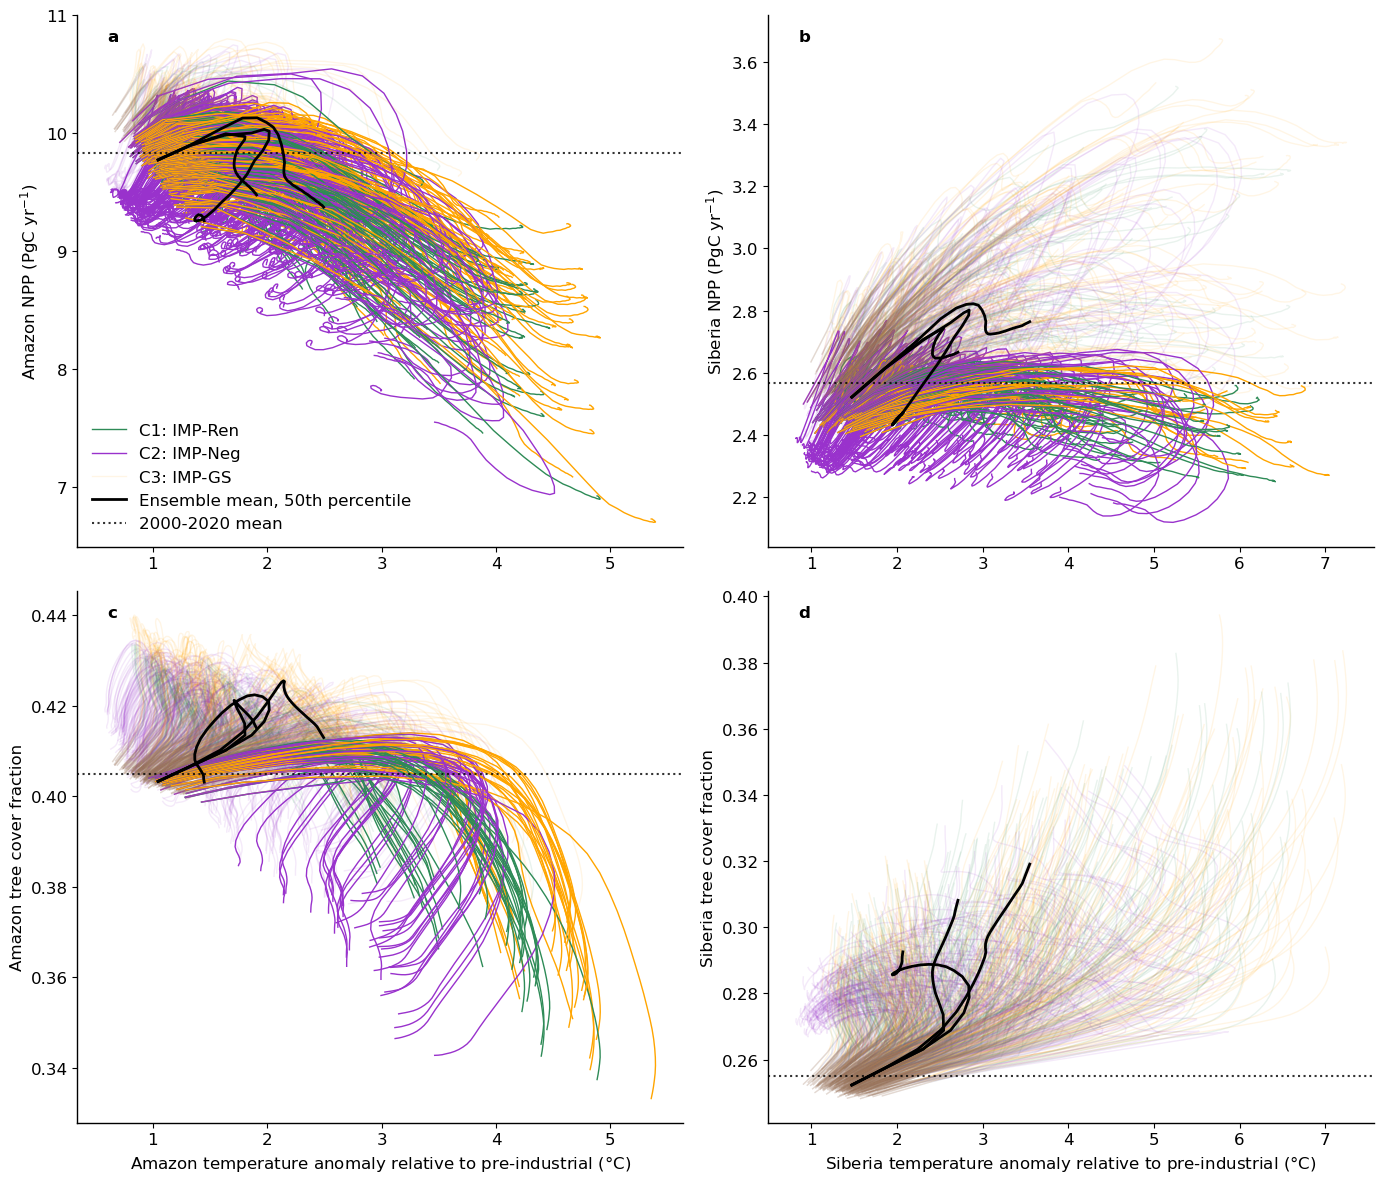

In [22]:
matplotlib.rcParams.update({'font.size': 12})

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

frac_med_amazon = frac_area_list_amazon_stats[0]
npp_med_amazon = npp_area_list_amazon_stats[0]
frac_med_siberia = frac_area_list_siberia_stats[0]
npp_med_siberia = npp_area_list_siberia_stats[0]

overshoot_peak_ms = 90
linealpha=1
lineps=20
endofline_size=90

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# plt.suptitle('ECS all percentiles, all ESMs')

last_perc = len(percentiles) - 1
last_cube = len(temp_mean_amazon['C1-IMP-Ren']['0.0']) - 10

for j, p in enumerate(percentiles):
    try:
        for i, _ in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.0']):
            if np.sum(frac_amazon['C1-IMP-Ren'][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                c1_alpha = 1
            else: 
                c1_alpha = 0.1
            if np.sum(frac_amazon['C2-IMP-Neg'][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                c2_alpha = 1
            else:
                c2_alpha = 0.1
            if np.sum(frac_amazon['C3-IMP-GS'][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                c3_alpha = 1
            else:
                c3_alpha = 0.1

            if np.sum(frac_siberia['C1-IMP-Ren'][p][i][25, :5].data, axis=0) < frac_baseline_siberia:
                c1_alpha_s = 1
            else: 
                c1_alpha_s = 0.1
            if np.sum(frac_siberia['C2-IMP-Neg'][p][i][25, :5].data, axis=0) < frac_baseline_siberia:
                c2_alpha_s = 1
            else:
                c2_alpha_s = 0.1
            if np.sum(frac_siberia['C3-IMP-GS'][p][i][25, :5].data, axis=0) < frac_baseline_siberia:
                c3_alpha_s = 1
            else:
                c3_alpha_s = 0.1

            # Tree fraction
            ax[1, 0].plot(temp_mean_amazon['C1-IMP-Ren'][p][i][-decs:].data, np.sum(frac_amazon['C1-IMP-Ren'][p][i][-decs:, :5].data, axis=1), color='seagreen', linewidth=1, alpha=c1_alpha, label="C1: IMP-Ren" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[1, 0].plot(temp_mean_amazon['C2-IMP-Neg'][p][i][-decs:].data, np.sum(frac_amazon['C2-IMP-Neg'][p][i][-decs:, :5].data, axis=1), color='darkorchid', linewidth=1, alpha=c2_alpha, label="C2: IMP-Neg" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[1, 0].plot(temp_mean_amazon['C3-IMP-GS'][p][i][-decs:].data, np.sum(frac_amazon['C3-IMP-GS'][p][i][-decs:, :5].data, axis=1), color='orange', linewidth=1, alpha=c3_alpha, label="C3: IMP-GS" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[1, 1].plot(temp_mean_siberia['C1-IMP-Ren'][p][i][-decs:].data, np.sum(frac_siberia['C1-IMP-Ren'][p][i][-decs:, :5].data, axis=1), color='seagreen', linewidth=1, alpha=c1_alpha_s)
            ax[1, 1].plot(temp_mean_siberia['C2-IMP-Neg'][p][i][-decs:].data, np.sum(frac_siberia['C2-IMP-Neg'][p][i][-decs:, :5].data, axis=1), color='darkorchid', linewidth=1, alpha=c2_alpha_s)
            ax[1, 1].plot(temp_mean_siberia['C3-IMP-GS'][p][i][-decs:].data, np.sum(frac_siberia['C3-IMP-GS'][p][i][-decs:, :5].data, axis=1), color='orange', linewidth=1, alpha=c3_alpha_s)
            
            # NPP
            if npp_amazon['C1-IMP-Ren'][p][i][25].data < npp_baseline_amazon:
                c1_alpha_npp = 1
            else: 
                c1_alpha_npp = 0.1
            if npp_amazon['C2-IMP-Neg'][p][i][25].data < npp_baseline_amazon:
                c2_alpha_npp = 1
            else:
                c2_alpha_npp = 0.1
            if npp_amazon['C3-IMP-GS'][p][i][25].data < npp_baseline_amazon:
                c3_alpha_npp = 1
            else:
                c3_alpha_npp = 0.1

            if npp_siberia['C1-IMP-Ren'][p][i][25].data < npp_baseline_siberia:
                c1_alpha_npp_s = 1
            else: 
                c1_alpha_npp_s = 0.1
            if npp_siberia['C2-IMP-Neg'][p][i][25].data < npp_baseline_siberia:
                c2_alpha_npp_s = 1
            else:
                c2_alpha_npp_s = 0.1
            if npp_siberia['C3-IMP-GS'][p][i][25].data < npp_baseline_siberia:
                c3_alpha_npp_s = 1
            else:
                c3_alpha_npp_s = 0.1

            ax[0, 0].plot(temp_mean_amazon['C1-IMP-Ren'][p][i][-decs:].data , npp_amazon['C1-IMP-Ren'][p][i][-decs:].data*amazon_conv, color='seagreen', linewidth=1, alpha=c1_alpha_npp, label="C1: IMP-Ren" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[0, 0].plot(temp_mean_amazon['C2-IMP-Neg'][p][i][-decs:].data, npp_amazon['C2-IMP-Neg'][p][i][-decs:].data*amazon_conv, color='darkorchid', linewidth=1, alpha=c2_alpha_npp, label="C2: IMP-Neg" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[0, 0].plot(temp_mean_amazon['C3-IMP-GS'][p][i][-decs:].data, npp_amazon['C3-IMP-GS'][p][i][-decs:].data*amazon_conv, color='orange', linewidth=1, alpha=c3_alpha_npp, label="C3: IMP-GS" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[0, 1].plot(temp_mean_siberia['C1-IMP-Ren'][p][i][-decs:].data , npp_siberia['C1-IMP-Ren'][p][i][-decs:].data*siberia_conv, color='seagreen', linewidth=1, alpha=c1_alpha_npp_s)
            ax[0, 1].plot(temp_mean_siberia['C2-IMP-Neg'][p][i][-decs:].data, npp_siberia['C2-IMP-Neg'][p][i][-decs:].data*siberia_conv, color='darkorchid', linewidth=1, alpha=c2_alpha_npp_s)
            ax[0, 1].plot(temp_mean_siberia['C3-IMP-GS'][p][i][-decs:].data, npp_siberia['C3-IMP-GS'][p][i][-decs:].data*siberia_conv, color='orange', linewidth=1, alpha=c3_alpha_npp_s)
            
    except:
        pass
    
# Plot 50th percentile, ESM medians TREE FRAC
ax[1, 0].plot(np.mean([temp_mean_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.5'])], axis=0), np.mean([np.sum(frac_amazon['C1-IMP-Ren']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_amazon['C1-IMP-Ren']['0.5'])], axis=0), color='black', label='Ensemble mean, 50th percentile', linewidth=2)
ax[1, 0].plot(np.mean([temp_mean_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C2-IMP-Neg']['0.5'])], axis=0), np.mean([np.sum(frac_amazon['C2-IMP-Neg']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_amazon['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 0].plot(np.mean([temp_mean_amazon['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C3-IMP-GS']['0.5'])], axis=0), np.mean([np.sum(frac_amazon['C3-IMP-GS']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_amazon['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 1].plot(np.mean([temp_mean_siberia['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C1-IMP-Ren']['0.5'])], axis=0), np.mean([np.sum(frac_siberia['C1-IMP-Ren']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_siberia['C1-IMP-Ren']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 1].plot(np.mean([temp_mean_siberia['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C2-IMP-Neg']['0.5'])], axis=0), np.mean([np.sum(frac_siberia['C2-IMP-Neg']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_siberia['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 1].plot(np.mean([temp_mean_siberia['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C3-IMP-GS']['0.5'])], axis=0), np.mean([np.sum(frac_siberia['C3-IMP-GS']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_siberia['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)

# Plot 50th percentile, ESM medians NPP
ax[0, 0].plot(np.mean([temp_mean_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.5'])], axis=0), np.mean([npp_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data*amazon_conv for i, mod in enumerate(npp_amazon['C1-IMP-Ren']['0.5'])], axis=0), color='black', label='Ensemble mean, 50th percentile', linewidth=2)
ax[0, 0].plot(np.mean([temp_mean_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C2-IMP-Neg']['0.5'])], axis=0), np.mean([npp_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data*amazon_conv for i, mod in enumerate(npp_amazon['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 0].plot(np.mean([temp_mean_amazon['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C3-IMP-GS']['0.5'])], axis=0), np.mean([npp_amazon['C3-IMP-GS']['0.5'][i][-decs:].data*amazon_conv for i, mod in enumerate(npp_amazon['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 1].plot(np.mean([temp_mean_siberia['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C1-IMP-Ren']['0.5'])], axis=0), np.mean([npp_siberia['C1-IMP-Ren']['0.5'][i][-decs:].data*siberia_conv for i, mod in enumerate(npp_siberia['C1-IMP-Ren']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 1].plot(np.mean([temp_mean_siberia['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C2-IMP-Neg']['0.5'])], axis=0), np.mean([npp_siberia['C2-IMP-Neg']['0.5'][i][-decs:].data*siberia_conv for i, mod in enumerate(npp_siberia['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 1].plot(np.mean([temp_mean_siberia['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C3-IMP-GS']['0.5'])], axis=0), np.mean([npp_siberia['C3-IMP-GS']['0.5'][i][-decs:].data*siberia_conv for i, mod in enumerate(npp_siberia['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)

# Axes labels
ax[1, 0].set_ylabel('Amazon tree cover fraction')
ax[1, 0].set_xlabel('Amazon temperature anomaly relative to pre-industrial ($\degree$C)')
ax[1, 1].set_ylabel('Siberia tree cover fraction')

ax[0, 0].set_ylabel('Amazon NPP (PgC yr$^{-1}$)')
ax[1, 1].set_xlabel('Siberia temperature anomaly relative to pre-industrial ($\degree$C)')
ax[0, 1].set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

# 2000-2020 mean hlines
ax[1, 0].axhline(frac_baseline_amazon, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)
ax[1, 1].axhline(frac_baseline_siberia, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)
ax[0, 0].axhline(npp_baseline_amazon*amazon_conv, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)
ax[0, 1].axhline(npp_baseline_siberia*siberia_conv, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)

# Region annotations
ax[0, 0].text(0.05, 0.95, 'a', transform=ax[0, 0].transAxes, color='black', weight='bold')
ax[0, 1].text(0.05, 0.95, 'b', transform=ax[0, 1].transAxes, color='black', weight='bold')
ax[1, 0].text(0.05, 0.95, 'c', transform=ax[1, 0].transAxes, color='black', weight='bold')
ax[1, 1].text(0.05, 0.95, 'd', transform=ax[1, 1].transAxes, color='black', weight='bold')

ax[0, 0].legend(loc='lower left', frameon=False)

ax[0, 0].spines[['right', 'top']].set_visible(False)
ax[0, 1].spines[['right', 'top']].set_visible(False)
ax[1, 0].spines[['right', 'top']].set_visible(False)
ax[1, 1].spines[['right', 'top']].set_visible(False)

for axis in ['top','bottom','left','right']:
    ax[0, 0].spines[axis].set_linewidth(1)
    ax[0, 1].spines[axis].set_linewidth(1)
    ax[1, 0].spines[axis].set_linewidth(1)
    ax[1, 1].spines[axis].set_linewidth(1)

plt.tight_layout()

In [18]:
### 2100 Models ###

c1_frac_models = []
c2_frac_models = []
c3_frac_models = []

c1_temp_frac_models = []
c2_temp_frac_models = []
c3_temp_frac_models = []

c1_precip_frac_models = []
c2_precip_frac_models = []
c3_precip_frac_models = []

c1_gtemp_models = []
c2_gtemp_models = []
c3_gtemp_models = []

### 2300 models ###

c1_frac_models_l = []
c2_frac_models_l = []
c3_frac_models_l = []

c1_temp_frac_models_l = []
c2_temp_frac_models_l = []
c3_temp_frac_models_l = []

c1_precip_frac_models_l = []
c2_precip_frac_models_l = []
c3_precip_frac_models_l = []

c1_gtemp_models_l = []
c2_gtemp_models_l = []
c3_gtemp_models_l = []

### Not models ###

not_temps = []
not_gtemps = []
not_precip = []

c1_frac_not_2100 = []
c2_frac_not_2100 = []
c3_frac_not_2100 = []

c1_frac_not_2300 = []
c2_frac_not_2300 = []
c3_frac_not_2300 = []

dec = 25

for scen in scenarios:
    for j, p in enumerate(percentiles):
        for i, _ in enumerate(temp_mean_amazon[scen][p]):
            # Select fracs that come in below present day threshold in 2100
            if np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_models.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    c1_temp_frac_models.append(temp_amazon[scen][p][i][dec].data)
                    c1_precip_frac_models.append(precip_amazon[scen][p][i][dec].data)
                    c1_gtemp_models.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C2-IMP-Neg':       
                    c2_frac_models.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    c2_temp_frac_models.append(temp_amazon[scen][p][i][dec].data)
                    c2_precip_frac_models.append(precip_amazon[scen][p][i][dec].data)
                    c2_gtemp_models.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_models.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    c3_temp_frac_models.append(temp_amazon[scen][p][i][dec].data)
                    c3_precip_frac_models.append(precip_amazon[scen][p][i][dec].data)
                    c3_gtemp_models.append(gtemp_dict[scen][p][dec])
                    
            # Select models that fall below present-day threshold in 2300
            if np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_models_l.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
                    c1_temp_frac_models_l.append(temp_amazon[scen][p][i][dec].data)
                    c1_precip_frac_models_l.append(precip_amazon[scen][p][i][dec].data)
                    c1_gtemp_models_l.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C2-IMP-Neg':
                    c2_frac_models_l.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
                    c2_temp_frac_models_l.append(temp_amazon[scen][p][i][dec].data)
                    c2_precip_frac_models_l.append(precip_amazon[scen][p][i][dec].data)
                    c2_gtemp_models_l.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_models_l.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
                    c3_temp_frac_models_l.append(temp_amazon[scen][p][i][dec].data)
                    c3_precip_frac_models_l.append(precip_amazon[scen][p][i][dec].data)
                    c3_gtemp_models_l.append(gtemp_dict[scen][p][dec])
                    
            # Select all models that don't fall below present-day threshold at 2100
            if not np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                not_temps.append(temp_amazon[scen][p][i][dec].data)
                not_precip.append(precip_amazon[scen][p][i][dec].data)
                not_gtemps.append(gtemp_dict[scen][p][dec])
                
            # Select specific scenario models that don't fall below present-day threshold at 2100
            if not np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_not_2100.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))

                if scen == 'C2-IMP-Neg':
                    c2_frac_not_2100.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_not_2100.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    
            # Select models that don't fall below threshold at 2300
            if not np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_not_2300.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))

                if scen == 'C2-IMP-Neg':
                    c2_frac_not_2300.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_not_2300.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))

In [20]:
# Combine scenarios for group statistics
temp_models = c1_temp_frac_models + c2_temp_frac_models + c3_temp_frac_models
gtemp_models = c1_gtemp_models + c2_gtemp_models + c3_gtemp_models
temp_models_l = c1_temp_frac_models_l + c2_temp_frac_models_l + c3_temp_frac_models_l
gtemp_models_l = c1_gtemp_models_l + c2_gtemp_models_l + c3_gtemp_models_l
precip_models = c1_precip_frac_models + c2_precip_frac_models + c3_precip_frac_models
precip_models_l = c1_precip_frac_models_l + c2_precip_frac_models_l + c3_precip_frac_models_l

# Calculate mean temperature of all models that don't pass threshold by 2100
mean_temp = np.mean(not_temps + temp_models)
mean_gtemp = np.mean(not_gtemps)
mean_precip = np.mean(not_precip + precip_models)

twosig_temp = np.percentile(temp_models, 5)
twosig_gtemp = np.percentile(gtemp_models, 5)
twosig_precip = np.percentile(precip_models, 95)

twosig_temp_l = np.percentile(temp_models_l, 5)
twosig_gtemp_l = np.percentile(gtemp_models_l, 5)
twosig_precip_l =  np.percentile(precip_models_l, 95)

Load in list of models

In [36]:
models = []
with open('models.txt', 'r') as f:
    for line in f:
        models.append(line.rstrip())

In [70]:
amazon_temps = []
global_temps = []
temp_dict = {}
global_dict = {}

for model in models:
    temp_dict[model] = []
    global_dict[model] = []

for scen in scenarios:
    for p in percentiles:
        for i, m in enumerate(models):
            temp_dict[m].append(temp_amazon[scen][p][i].data)
            global_dict[m].append(gtemp_dict[scen][p])
            
            amazon_temps.append(temp_amazon[scen][p][i].data)
            global_temps.append(gtemp_dict[scen][p])
        
for model in models:
    temp_dict[model] = np.concatenate(np.array(temp_dict[model]))
    global_dict[model] = np.concatenate(np.array(global_dict[model]))
        
amazon_temps = np.concatenate(np.array(amazon_temps))
global_temps = np.concatenate(np.array(global_temps))

In [71]:
m, c, r, p, se = scipy.stats.linregress(global_temps, amazon_temps)
y = m*global_temps

print(f'Global temp 1.5, Amazon temp = {1.5*m}')
print(f'Global temp 2.0, Amazon temp = {2.0*m}')

lower_temp = 1.5*m
upper_temp = 2.0*m

Global temp 1.5, Amazon temp = 1.793361914148052
Global temp 2.0, Amazon temp = 2.391149218864069


In [72]:
y_err = ((y - amazon_temps)**2 + (global_temps - (global_temps))**2)**0.5

m_upp, c, r, p, se = scipy.stats.linregress(global_temps, y+y_err)
upper_error = m_upp*global_temps

m_low, c, r, p, se = scipy.stats.linregress(global_temps, y-y_err)
lower_error = m_low*global_temps

In [73]:
lb = twosig_temp / m_upp
ub = twosig_temp / m_low

lb2 = twosig_temp_l / m_upp
ub2 = twosig_temp_l / m_low

print(f'Lower bound at higher temp: {lb}')
print(f'Upper bound at higher temp: {ub}')
print(f'Lower bound at lower temp: {lb2}')
print(f'Upper bound at lower temp: {ub2}')

Lower bound at higher temp: 1.9951782979376855
Upper bound at higher temp: 2.3052103341358543
Lower bound at lower temp: 1.2741600497668788
Upper bound at lower temp: 1.4721525976408751


## Extended Data Figure 3

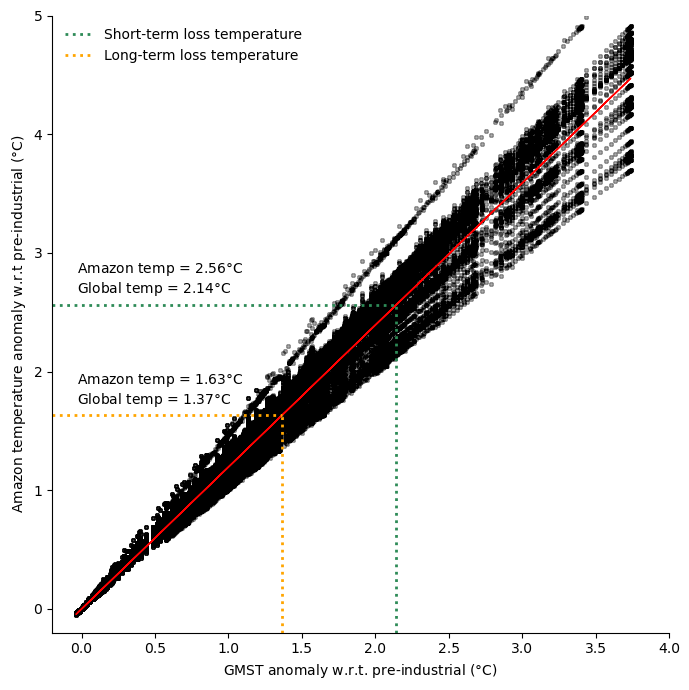

In [74]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)

for scen in scenarios:
    for p in percentiles:
        ax.scatter(global_temps, amazon_temps, color='k', marker='o', s=8, alpha=0.01)
ax.plot(global_temps, y, color='red', lw=1)
# ax.plot(global_temps, upper_error, color='red', ls=':', lw=1) 
# ax.plot(global_temps, lower_error, color='red', ls=':', lw=1) 

# Plot temperature correspondence
ax.plot([twosig_temp / m, twosig_temp / m], [-0.2, twosig_temp], color='seagreen', linestyle=':', lw=2, label='Short-term loss temperature')
ax.plot([-0.2, twosig_temp / m], [twosig_temp, twosig_temp], color='seagreen', linestyle=':', lw=2)

ax.plot([twosig_temp_l / m, twosig_temp_l / m], [-0.2, twosig_temp_l], color='orange', linestyle=':', lw=2, label='Long-term loss temperature')
ax.plot([-0.2, twosig_temp_l / m], [twosig_temp_l, twosig_temp_l], color='orange', linestyle=':', lw=2)

ax.text(0.04, 0.55, f'Amazon temp = {(twosig_temp):.2f}$\degree$C\nGlobal temp = {(twosig_temp / m):.2f}$\degree$C', transform=ax.transAxes, color='black', ha="left")
ax.text(0.04, 0.37, f'Amazon temp = {(twosig_temp_l):.2f}$\degree$C\nGlobal temp = {(twosig_temp_l / m):.2f}$\degree$C', transform=ax.transAxes, color='black', ha="left")

ax.set_xlabel('GMST anomaly w.r.t. pre-industrial ($\degree$C)')
ax.set_ylabel('Amazon temperature anomaly w.r.t pre-industrial ($\degree$C)')
ax.set_xlim([-0.2, 4])
ax.set_ylim([-0.2, 5])

plt.legend(loc='upper left', frameon=False)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)

In [75]:
print(f'Total number of models: {len(not_temps) + len(temp_models)}')

Total number of models: 918


In [76]:
frac_models = c1_frac_models + c2_frac_models + c3_frac_models
frac_models_l = c1_frac_models_l + c2_frac_models_l + c3_frac_models_l

In [77]:
# Calculate probability of tree loss, in 2100 danger zone
models_not_exceed = [temp for i, temp in enumerate(not_temps) if ((temp >= twosig_temp) and (not_precip[i] <= twosig_precip))]
models_exceed = [temp for i, temp in enumerate(temp_models) if ((temp >= twosig_temp) and (precip_models[i] <= twosig_precip))]
exceedence_2100_prob_danger = (len(models_exceed) / (len(models_exceed) + len(models_not_exceed))) * 100
print(f'Probability of exceeding in 2100, if in 2100 danger zone: {exceedence_2100_prob_danger}')

models_not_exceed_l = [temp for i, temp in enumerate(not_temps) if ((temp >= twosig_temp_l) and (not_precip[i] <= twosig_precip_l))]
models_exceed_l = [temp for i, temp in enumerate(temp_models_l) if ((temp >= twosig_temp_l) and (precip_models_l[i] <= twosig_precip_l))]
exceedence_2100_prob_danger_l = (len(models_exceed_l) / (len(models_exceed_l) + len(models_not_exceed_l))) * 100
print(f'Probability of exceeding in 2300, if in 2100 danger zone: {exceedence_2100_prob_danger_l}')

Probability of exceeding in 2100, if in 2100 danger zone: 51.33689839572193
Probability of exceeding in 2300, if in 2100 danger zone: 48.03370786516854


In [78]:
# Calculate probability of tree loss, in 2100 danger zone
models_not_exceed = [temp for i, temp in enumerate(not_temps) if (temp >= lower_temp) and (not_precip[i] <= twosig_precip)]
models_exceed = [temp for i, temp in enumerate(temp_models) if (temp >= lower_temp) and (precip_models[i] <= twosig_precip)]
exceedence_2100_prob_danger = (len(models_exceed) / (len(models_exceed) + len(models_not_exceed))) * 100
print(f'Probability of exceeding, if in 2100 1.5C danger zone: {exceedence_2100_prob_danger}')

models_not_exceed = [temp for i, temp in enumerate(not_temps) if (temp >= upper_temp) and (not_precip[i] <= twosig_precip)]
models_exceed = [temp for i, temp in enumerate(temp_models) if (temp >= upper_temp) and (precip_models[i] <= twosig_precip)]
exceedence_2100_prob_danger = (len(models_exceed) / (len(models_exceed) + len(models_not_exceed))) * 100
print(f'Probability of exceeding, if in 2100 2.0C danger zone: {exceedence_2100_prob_danger}')

# Calculate probability of tree loss, in 2300 danger zone
models_not_exceed_l = [temp for i, temp in enumerate(not_temps) if (temp >= lower_temp) and (not_precip[i] <= twosig_precip_l)]
models_exceed_l = [temp for i, temp in enumerate(temp_models_l) if ((temp >= lower_temp) and (precip_models_l[i] <= twosig_precip_l))]
exceedence_2300_prob_danger = (len(models_exceed_l) / (len(models_exceed_l) + len(models_not_exceed_l))) * 100
print(f'Probability of exceeding, if in 2300 1.5C danger zone: {exceedence_2300_prob_danger}')

models_not_exceed_l = [temp for i, temp in enumerate(not_temps) if (temp >= upper_temp) and (not_precip[i] <= twosig_precip_l)]
models_exceed_l = [temp for i, temp in enumerate(temp_models_l) if ((temp >= upper_temp) and (precip_models_l[i] <= twosig_precip_l))]
exceedence_2300_prob_danger = (len(models_exceed_l) / (len(models_exceed_l) + len(models_not_exceed_l))) * 100
print(f'Probability of exceeding, if in 2300 2.0C danger zone: {exceedence_2300_prob_danger}')

Probability of exceeding, if in 2100 1.5C danger zone: 30.357142857142854
Probability of exceeding, if in 2100 2.0C danger zone: 44.29824561403509
Probability of exceeding, if in 2300 1.5C danger zone: 51.533742331288344
Probability of exceeding, if in 2300 2.0C danger zone: 61.21951219512195


Probability of loss if above temp threshold

## Extended Data Figure 1

Amazon area = 8565704.941716159
Average loss at 2100: 65547.79053313597 (0.77% decrease)
Average loss at 2300: 159044.61788196088 (1.86% decrease)
Max loss at 2100: 225512.99607599765
Max loss at 2300: 614223.1802378496
Min loss at 2100: 17.29459284592983
Min loss at 2300: 683.0270640334894


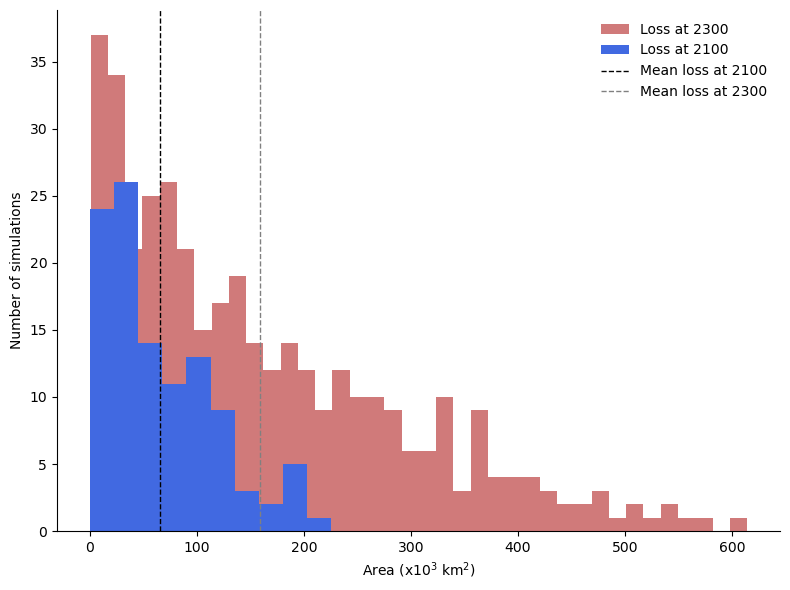

In [80]:
frac_loss = (frac_baseline_amazon - np.mean(frac_models)) * amazon_area / 1e6
frac_loss_l = (frac_baseline_amazon - np.mean(frac_models_l)) * amazon_area / 1e6
print(f'Amazon area = {amazon_area/1e6}')
print(f'Average loss at 2100: {frac_loss} ({(frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {frac_loss_l} ({(frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')

min_loss = (frac_baseline_amazon - np.max(frac_models)) * amazon_area / 1e6
min_loss_l = (frac_baseline_amazon - np.max(frac_models_l)) * amazon_area / 1e6 
max_loss = (frac_baseline_amazon - np.min(frac_models)) * amazon_area / 1e6
max_loss_l = (frac_baseline_amazon - np.min(frac_models_l)) * amazon_area / 1e6 
print(f'Max loss at 2100: {max_loss}')
print(f'Max loss at 2300: {max_loss_l}')
print(f'Min loss at 2100: {min_loss}')
print(f'Min loss at 2300: {min_loss_l}')

num_in_bins = 10
num_bins_l = int(len(frac_models_l) / num_in_bins)
num_bins = int(len(frac_models) / num_in_bins)

fig, ax = plt.subplots(figsize=(8, 6))

plt.hist((frac_baseline_amazon - np.array(frac_models_l)) * amazon_area / 1e9, bins=num_bins_l, color='firebrick', label='Loss at 2300', alpha=0.6)
plt.hist((frac_baseline_amazon - np.array(frac_models)) * amazon_area / 1e9, bins=num_bins, color='royalblue', label='Loss at 2100')

plt.axvline(frac_loss/1e3, color='black', linestyle='--', lw=1, label='Mean loss at 2100')
plt.axvline(frac_loss_l/1e3, color='gray', linestyle='--', lw=1, label='Mean loss at 2300')

plt.xlabel('Area (x10$^3$ km$^2$)')
plt.ylabel('Number of simulations')
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)

## Extended Data Figure 2

Average loss at 2100: 62785.347674950666 (0.73% decrease)
Average loss at 2100: 69952.98824962437 (0.82% decrease)
Average loss at 2100: 62934.36651236557 (0.73% decrease)
Average loss at 2300: 169051.61393587865 (1.97% decrease)
Average loss at 2300: 142412.69773225056 (1.66% decrease)
Average loss at 2300: 176328.0955157944 (2.06% decrease)


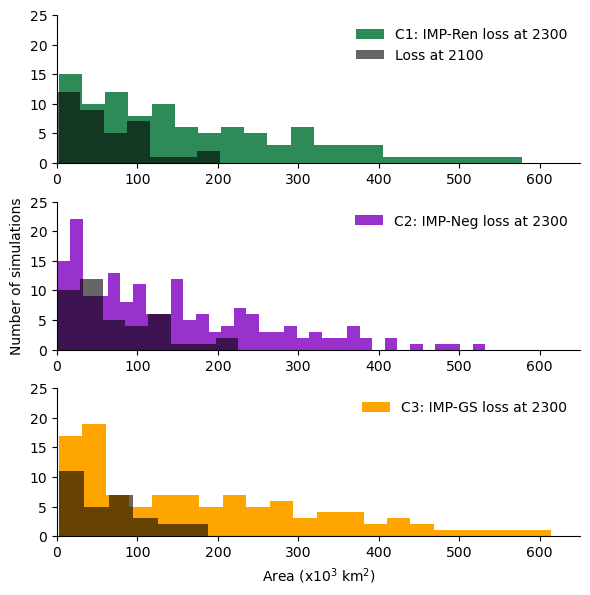

In [82]:
c1_frac_loss = (frac_baseline_amazon - np.mean(c1_frac_models)) * amazon_area / 1e6
c2_frac_loss = (frac_baseline_amazon - np.mean(c2_frac_models)) * amazon_area / 1e6
c3_frac_loss = (frac_baseline_amazon - np.mean(c3_frac_models)) * amazon_area / 1e6

c1_frac_loss_l = (frac_baseline_amazon - np.mean(c1_frac_models_l)) * amazon_area / 1e6
c2_frac_loss_l = (frac_baseline_amazon - np.mean(c2_frac_models_l)) * amazon_area / 1e6
c3_frac_loss_l = (frac_baseline_amazon - np.mean(c3_frac_models_l)) * amazon_area / 1e6

print(f'Average loss at 2100: {c1_frac_loss} ({(c1_frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2100: {c2_frac_loss} ({(c2_frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2100: {c3_frac_loss} ({(c3_frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {c1_frac_loss_l} ({(c1_frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {c2_frac_loss_l} ({(c2_frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {c3_frac_loss_l} ({(c3_frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')

num_in_bins2 = 5

c1_num_bins = int(len(c1_frac_models) / num_in_bins2)
c2_num_bins = int(len(c2_frac_models) / num_in_bins2)
c3_num_bins = int(len(c3_frac_models) / num_in_bins2)

c1_num_bins_l = int(len(c1_frac_models_l) / num_in_bins2)
c2_num_bins_l = int(len(c2_frac_models_l) / num_in_bins2)
c3_num_bins_l = int(len(c3_frac_models_l) / num_in_bins2)

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(311)

plt.hist((frac_baseline_amazon - np.array(c1_frac_models_l)) * amazon_area / 1e9, bins=c1_num_bins_l, color='seagreen', label='C1: IMP-Ren loss at 2300')
plt.hist((frac_baseline_amazon - np.array(c1_frac_models)) * amazon_area / 1e9, bins=c1_num_bins, color='black', alpha=0.6, label='Loss at 2100')

ax.set_xlim(0, 650)
ax.set_ylim(0, 25)
ax.legend(loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(312)

plt.hist((frac_baseline_amazon - np.array(c2_frac_models_l)) * amazon_area / 1e9, bins=c2_num_bins_l, color='darkorchid', label='C2: IMP-Neg loss at 2300')
plt.hist((frac_baseline_amazon - np.array(c2_frac_models)) * amazon_area / 1e9, bins=c2_num_bins, color='black', alpha=0.6)

ax.set_ylabel('Number of simulations')
ax.set_xlim(0, 650)
ax.set_ylim(0, 25)
ax.legend(loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(313)

plt.hist((frac_baseline_amazon - np.array(c3_frac_models_l)) * amazon_area / 1e9, bins=c3_num_bins_l, color='orange', label='C3: IMP-GS loss at 2300')
plt.hist((frac_baseline_amazon - np.array(c3_frac_models)) * amazon_area / 1e9, bins=c3_num_bins, color='black', alpha=0.6)

ax.set_xlim(0, 650)
ax.set_ylim(0, 25)

ax.set_xlabel('Area (x10$^3$ km$^2$)')
ax.legend(loc='upper right', frameon=False)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)

In [83]:
# Calculate probably of loss regardless of danger zone

exceed_2100 = [c1_frac_models, c2_frac_models, c3_frac_models]
exceed_2300 = [c1_frac_models_l, c2_frac_models_l, c3_frac_models_l]
not_exceed_2100 = [c1_frac_not_2100, c2_frac_not_2100, c3_frac_not_2100]
not_exceed_2300 = [c1_frac_not_2300, c2_frac_not_2300, c3_frac_not_2300]

for i, scen in enumerate(scenarios):
    exceedence_prob_2100 = (len(exceed_2100[i]) / (len(exceed_2100[i]) + len(not_exceed_2100[i]))) * 100
    exceedence_prob_2300 = (len(exceed_2300[i]) / (len(exceed_2300[i]) + len(not_exceed_2300[i]))) * 100
    print(f'Probability of {scen} exceeding by 2100: {exceedence_prob_2100}')
    print(f'Probability of {scen} exceeding by 2300: {exceedence_prob_2300}')
    
    print(f'Number of models exceeding by 2100 in {scen}: {len(exceed_2100[i])}')
    print(f'Number of models exceeding by 2300 in {scen}: {len(exceed_2300[i])}\n')
    
hist = np.array([[len(exceed_2100[0]), len(exceed_2300[0])], [len(exceed_2100[1]), len(exceed_2300[1])], [len(exceed_2100[2]), len(exceed_2300[2])]])

Probability of C1-IMP-Ren exceeding by 2100: 12.091503267973856
Probability of C1-IMP-Ren exceeding by 2300: 33.006535947712415
Number of models exceeding by 2100 in C1-IMP-Ren: 37
Number of models exceeding by 2300 in C1-IMP-Ren: 101

Probability of C2-IMP-Neg exceeding by 2100: 13.398692810457517
Probability of C2-IMP-Neg exceeding by 2300: 56.5359477124183
Number of models exceeding by 2100 in C2-IMP-Neg: 41
Number of models exceeding by 2300 in C2-IMP-Neg: 173

Probability of C3-IMP-GS exceeding by 2100: 9.803921568627452
Probability of C3-IMP-GS exceeding by 2300: 35.294117647058826
Number of models exceeding by 2100 in C3-IMP-GS: 30
Number of models exceeding by 2300 in C3-IMP-GS: 108



In [110]:
level_frac = 0.95

# Collect models which exceed but don't go below 10% of present-day level
c1_frac_models_med = np.array([x for x in c1_frac_models if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c2_frac_models_med = np.array([x for x in c2_frac_models if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c3_frac_models_med = np.array([x for x in c3_frac_models if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])

# Collect models which go below 10% of present-day level
c1_frac_models_big = np.array([x for x in c1_frac_models if x <= frac_baseline_amazon*level_frac]) 
c2_frac_models_big = np.array([x for x in c2_frac_models if x <= frac_baseline_amazon*level_frac]) 
c3_frac_models_big = np.array([x for x in c3_frac_models if x <= frac_baseline_amazon*level_frac]) 

big_exceed_2100 = [c1_frac_models_big, c2_frac_models_big, c3_frac_models_big]
med_exceed_2100 = [c1_frac_models_med, c2_frac_models_med, c3_frac_models_med]

for i, scen in enumerate(scenarios):
    exceedence_prob_2100 = (len(big_exceed_2100[i]) / (len(big_exceed_2100[i]) + len(med_exceed_2100[i]) + len(not_exceed_2100[i]))) * 100
    print(f'Probability of {scen} exceeding by 2100: {exceedence_prob_2100}')

Probability of C1-IMP-Ren exceeding by 2100: 0.6535947712418301
Probability of C2-IMP-Neg exceeding by 2100: 0.9803921568627451
Probability of C3-IMP-GS exceeding by 2100: 0.32679738562091504


In [105]:
level_frac = 0.9

# Collect models which exceed but don't go below 10% of present-day level
c1_frac_models_med = np.array([x for x in c1_frac_models_l if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c2_frac_models_med = np.array([x for x in c2_frac_models_l if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c3_frac_models_med = np.array([x for x in c3_frac_models_l if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])

# Collect models which go below 10% of present-day level
c1_frac_models_big_l = np.array([x for x in c1_frac_models_l if x <= frac_baseline_amazon*level_frac]) 
c2_frac_models_big_l = np.array([x for x in c2_frac_models_l if x <= frac_baseline_amazon*level_frac]) 
c3_frac_models_big_l = np.array([x for x in c3_frac_models_l if x <= frac_baseline_amazon*level_frac]) 

big_exceed_2300 = [c1_frac_models_big_l, c2_frac_models_big_l, c3_frac_models_big_l]
med_exceed_2300 = [c1_frac_models_med, c2_frac_models_med, c3_frac_models_med]

for i, scen in enumerate(scenarios):
    exceedence_prob_2300 = (len(big_exceed_2300[i]) / (len(big_exceed_2300[i]) + len(med_exceed_2300[i]) + len(not_exceed_2300[i]))) * 100
    print(f'Probability of {scen} exceeding by 2300: {exceedence_prob_2300}')

Probability of C1-IMP-Ren exceeding by 2300: 3.9215686274509802
Probability of C2-IMP-Neg exceeding by 2300: 3.9215686274509802
Probability of C3-IMP-GS exceeding by 2300: 5.228758169934641


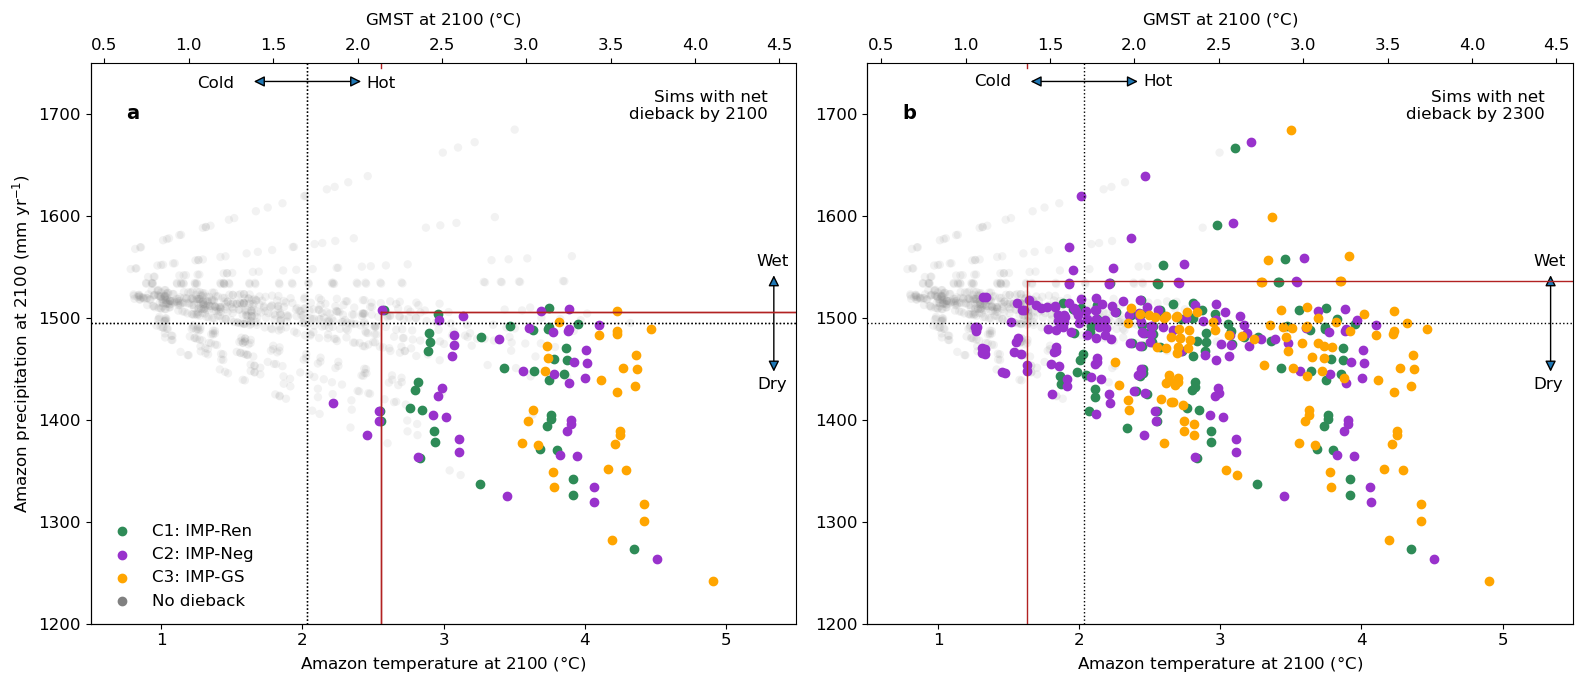

In [87]:
matplotlib.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(16, 7))
# gs = fig.add_gridspec(2, 2, height_ratios=[5, 1])

ax = fig.add_subplot(1, 2, 1)

# Greyed out points
ax.scatter(not_temps, np.array(not_precip)*60*60*24*360, color='grey', alpha=0.1, edgecolor='none')

# Climatic zones
ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[0,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp,twosig_temp+10],[twosig_precip*60*60*24*360,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)

# Exceedence points
ax.scatter(c1_temp_frac_models, np.array(c1_precip_frac_models)*60*60*24*360, color='seagreen', label='C1: IMP-Ren')
ax.scatter(c2_temp_frac_models, np.array(c2_precip_frac_models)*60*60*24*360, color='darkorchid', label='C2: IMP-Neg')
ax.scatter(c3_temp_frac_models, np.array(c3_precip_frac_models)*60*60*24*360, color='orange', label='C3: IMP-GS')

ax.scatter(-9, -9, color='grey', label='No dieback')

ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[0,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp,twosig_temp+10],[twosig_precip*60*60*24*360,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[1745,1750], color='firebrick', lw=1.0)

ax.set_xlabel('Amazon temperature at 2100 ($\degree$C)')
ax.set_ylabel('Amazon precipitation at 2100 (mm yr$^{-1}$)')
ax.set_xlim([0.5, 5.5])
ax.set_ylim([1200, 1750])
ax.text(0.05, 0.90, 'a', transform=ax.transAxes, color='black', weight='bold', fontsize=14)
ax.text(0.96, 0.90, 'Sims with net\ndieback by 2100', transform=ax.transAxes, color='black', ha='right')
ax.legend(loc='lower left', edgecolor='none')
ax.spines[['right', 'top']].set_visible(False)

p1 = patches.FancyArrowPatch((mean_temp-0.4, 1732), (mean_temp+0.4, 1732), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p1)
ax.text(mean_temp + 0.42, 1726, 'Hot', color='black')
ax.text(mean_temp - 0.78, 1726, 'Cold', color='black')

p2 = patches.FancyArrowPatch((5.34, mean_precip*60*60*24*360 - 50), (5.34, mean_precip*60*60*24*360 + 50), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p2)
ax.text(5.22, mean_precip*60*60*24*360 + 56, 'Wet', color='black')
ax.text(5.22, mean_precip*60*60*24*360 - 64, 'Dry', color='black')

ax2 = ax.twiny()

ax2.scatter(np.array(not_temps), np.array(not_precip)*60*60*24*360, color='grey', alpha=0, edgecolor='none')
ax2.scatter(np.array(c1_temp_frac_models)/m, np.array(c1_precip_frac_models)*60*60*24*360, alpha=0, color='seagreen')
ax2.scatter(np.array(c2_temp_frac_models)/m, np.array(c2_precip_frac_models)*60*60*24*360, alpha=0, color='darkorchid')
ax2.scatter(np.array(c3_temp_frac_models)/m, np.array(c3_precip_frac_models)*60*60*24*360, alpha=0, color='orange')
ax2.set_xlabel('GMST at 2100 ($\degree$C)', labelpad=10)
ax2.set_xlim([0.5/m, 5.5/m])

# ax.axvline(2.557)
ax = fig.add_subplot(1, 2, 2)

# Greyed out points
ax.scatter(not_temps, np.array(not_precip)*60*60*24*360, color='grey', alpha=0.1, edgecolor='none')

# Climatic zones 
ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l],[0,twosig_precip_l*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l+10],[twosig_precip_l*60*60*24*360,twosig_precip_l*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l],[1745,1750], color='firebrick', lw=1.0)

# Exceedence points
ax.scatter(c1_temp_frac_models_l, np.array(c1_precip_frac_models_l)*60*60*24*360, color='seagreen')
ax.scatter(c2_temp_frac_models_l, np.array(c2_precip_frac_models_l)*60*60*24*360, color='darkorchid')
ax.scatter(c3_temp_frac_models_l, np.array(c3_precip_frac_models_l)*60*60*24*360, color='orange')

ax.set_xlabel('Amazon temperature at 2100 ($\degree$C)')
# ax.set_ylabel('Amazon precipitation at 2100 (mm yr$^{-1}$)')
ax.set_xlim([0.5, 5.5])
ax.set_ylim([1200, 1750])
ax.text(0.05, 0.90, 'b', transform=ax.transAxes, color='black', weight='bold', fontsize=14)
ax.text(0.96, 0.90, 'Sims with net\ndieback by 2300', transform=ax.transAxes, color='black', ha='right')
ax.spines[['right', 'top']].set_visible(False)

p1 = patches.FancyArrowPatch((mean_temp-0.4, 1732), (mean_temp+0.4, 1732), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p1)
ax.text(mean_temp + 0.42, 1728, 'Hot', color='black')
ax.text(mean_temp - 0.78, 1728, 'Cold', color='black')

p2 = patches.FancyArrowPatch((5.34, mean_precip*60*60*24*360 - 50), (5.34, mean_precip*60*60*24*360 + 50), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p2)
ax.text(5.22, mean_precip*60*60*24*360 + 56, 'Wet', color='black')
ax.text(5.22, mean_precip*60*60*24*360 - 64, 'Dry', color='black')

ax2 = ax.twiny()

ax2.scatter(np.array(not_temps), np.array(not_precip)*60*60*24*360, color='grey', alpha=0, edgecolor='none')
ax2.scatter((np.array(c1_temp_frac_models_l)/m), np.array(c1_precip_frac_models_l)*60*60*24*360, alpha=0, color='seagreen')
ax2.scatter((np.array(c2_temp_frac_models_l)/m), np.array(c2_precip_frac_models_l)*60*60*24*360, alpha=0, color='darkorchid')
ax2.scatter((np.array(c3_temp_frac_models_l)/m), np.array(c3_precip_frac_models_l)*60*60*24*360, alpha=0, color='orange')
ax2.set_xlim([0.5/m, 5.5/m])

ax2.set_xlabel('GMST at 2100 ($\degree$C)', labelpad=10)

plt.tight_layout()